# Wise MXN→USD Route Analysis: Data Processing & Exploratory Analysis

## Executive Summary

This notebook transforms raw event data from the MXN→USD route launch into analysis-ready datasets and conducts comprehensive exploratory data analysis. We examine funnel performance across regions, platforms, and user experience segments.

## Objectives

1. **Data Processing**: Transform event-level data into transfer-level datasets
2. **Exploratory Analysis**: Identify performance patterns and anomalies
3. **Segment Analysis**: Compare success rates across key dimensions
4. **Time Series Analysis**: Track performance trends over time

## Key Definitions

- **Transfer States**: Created → Funded → Transferred (success path)
- **Success Criteria**: Transfers reaching "funded" or "transferred" status
- **Failure Definition**: Transfers that remain "unsettled" (created only)

## Setup & Data Loading

In [ ]:
# Import libraries and custom utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import os

# Add src directory to path for custom utilities
sys.path.append('..')
from src.funnel_utils import normalize_events, attach_transfer_keys, build_transfer_level, daily_funnel, global_daily, WISE_COLORS

# Configure display options
pd.set_option('display.max_columns', None)
plt.style.use('default')

In [ ]:
# Load raw event data
raw = pd.read_csv("../data/wise_funnel_events.csv", parse_dates=["dt"])
print(f"✓ Loaded {len(raw):,} events from {raw['dt'].min().date()} to {raw['dt'].max().date()}")

In [ ]:
### Data Quality Check
print("Dataset shape:", raw.shape)
print("\nColumn info:")
print(raw.info())
print(f"\nSample data:")
raw.head()

In [ ]:
## Data Processing Pipeline

### Transform Events to Transfer-Level Data
# Process raw events through our funnel analysis pipeline
df = normalize_events(raw, dt_col="dt")
df = attach_transfer_keys(df, dt_col="dt") 
transfers = build_transfer_level(df, dt_col="dt")

# Generate daily aggregations
daily = daily_funnel(transfers)
global_d = global_daily(daily)

# Save processed datasets
transfers.to_csv("../data/transfers_level.csv", index=False)
daily.to_csv("../data/daily_segmented.csv", index=False)
global_d.to_csv("../data/daily_global.csv", index=False)

print("✓ Data processing completed successfully")
print(f"✓ Generated {len(transfers):,} transfers from {len(raw):,} events")
print(f"✓ Created daily metrics for {len(daily):,} segment-days")

In [ ]:
### Transfer Funnel Summary
summary = {
    "total_transfers": len(transfers),
    "created_only": int(((transfers.transfer_created) & ~(transfers.transfer_funded | transfers.transfer_transferred)).sum()),
    "created_and_funded": int(((transfers.transfer_created) & (transfers.transfer_funded) & ~transfers.transfer_transferred).sum()), 
    "fully_settled": int(((transfers.transfer_created) & (transfers.transfer_funded) & (transfers.transfer_transferred)).sum()),
}

print("📊 TRANSFER FUNNEL OVERVIEW")
print("="*40)
for key, value in summary.items():
    pct = (value / summary['total_transfers']) * 100
    print(f"{key.replace('_', ' ').title():<20}: {value:,} ({pct:.1f}%)")

summary

In [ ]:
## Exploratory Data Analysis

### Segment Distribution Analysis
n_users = transfers["user_id"].nunique()
by_region = transfers.groupby("region").size().sort_values(ascending=False)
by_platform = transfers.groupby("platform").size().sort_values(ascending=False)
by_experience = transfers.groupby("experience").size().sort_values(ascending=False)

print(f"📈 SEGMENT DISTRIBUTION")
print("="*30)
print(f"Total Users: {n_users:,}")
print(f"\nBy Region:")
for region, count in by_region.items():
    print(f"  {region:<10}: {count:,} ({count/len(transfers)*100:.1f}%)")
    
print(f"\nBy Platform:")  
for platform, count in by_platform.items():
    print(f"  {platform:<10}: {count:,} ({count/len(transfers)*100:.1f}%)")
    
print(f"\nBy Experience:")
for exp, count in by_experience.items():
    print(f"  {exp:<10}: {count:,} ({count/len(transfers)*100:.1f}%)")

In [ ]:
### Regional Distribution Visualization

plt.figure(figsize=(10, 6))
plt.bar(by_region.index.astype(str), by_region.values, color=WISE_COLORS[0])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Number of Transfers")
plt.title("Transfer Distribution by Region")

# Add percentage labels on bars
for i, (region, count) in enumerate(by_region.items()):
    pct = count/len(transfers)*100
    plt.text(i, count + len(transfers)*0.01, f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("🚨 KEY INSIGHT: Despite MXN→USD being a Mexico-US route, 'Other' and 'Europe' show higher volumes than 'NorthAm'")

In [ ]:
### Platform Distribution by Region

pivot = transfers.groupby(["region","platform"])["user_id"].nunique().unstack(fill_value=0)

plt.figure(figsize=(12,7))
bottom = None
for i, col in enumerate(pivot.columns):
    vals = pivot[col].values
    plt.bar(pivot.index, vals, bottom=bottom, label=col, color=WISE_COLORS[i % len(WISE_COLORS)])
    bottom = vals if bottom is None else bottom + vals

plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Unique Users") 
plt.title("Platform Distribution by Region (Stacked)")
plt.legend(title="Platform", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [ ]:
### Platform Mix by Region (Percentage)

pivot_perc = pivot.div(pivot.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12,7))
bottom = None
for i, col in enumerate(pivot_perc.columns):
    vals = pivot_perc[col].values
    plt.bar(pivot_perc.index, vals, bottom=bottom, label=col, color=WISE_COLORS[i % len(WISE_COLORS)])
    bottom = vals if bottom is None else bottom + vals

plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Percentage of Users (%)")
plt.title("Platform Mix by Region (100% Stacked)")
plt.legend(title="Platform", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

print("📊 INSIGHT: iOS dominates in NorthAm and Europe, while Android leads in 'Other' regions")

## Time Series Analysis

### Overview

This section examines how transfer volumes and success rates evolved over time, with particular attention to identifying unusual patterns or system issues.

In [ ]:
### Transfer Volume Trends by Segment

# Analyze how transfer volumes changed over time across different segments
dims = ["region", "platform", "experience"]

for dim in dims:
    # Aggregate daily transfer counts
    tmp = (daily.groupby(["created_date", dim], dropna=False)["created"]
           .sum().reset_index(name="count"))
    
    # Compute 7-day moving average
    tmp = tmp.sort_values(["created_date", dim])
    tmp["count_ma7"] = tmp.groupby(dim)["count"].transform(
        lambda s: s.rolling(7, min_periods=1).mean())
    
    # Pivot for visualization
    pivot = tmp.pivot(index="created_date", columns=dim, values="count_ma7").fillna(0)
    
    # Plot
    plt.figure(figsize=(12, 6))
    for i, cat in enumerate(pivot.columns):
        plt.plot(pivot.index, pivot[cat], label=str(cat), linewidth=2.5,
                color=WISE_COLORS[i % len(WISE_COLORS)])
    
    plt.title(f"Transfer Volume Trends by {dim.capitalize()} (7-Day MA)")
    plt.xlabel("Date")
    plt.ylabel("Daily Transfers (7-Day MA)")
    plt.xticks(rotation=45)
    plt.legend(title=dim.capitalize(), loc="best")
    plt.tight_layout()
    plt.show()

print("🚨 CRITICAL FINDING: Europe shows dramatic volume spike in early February 2024")

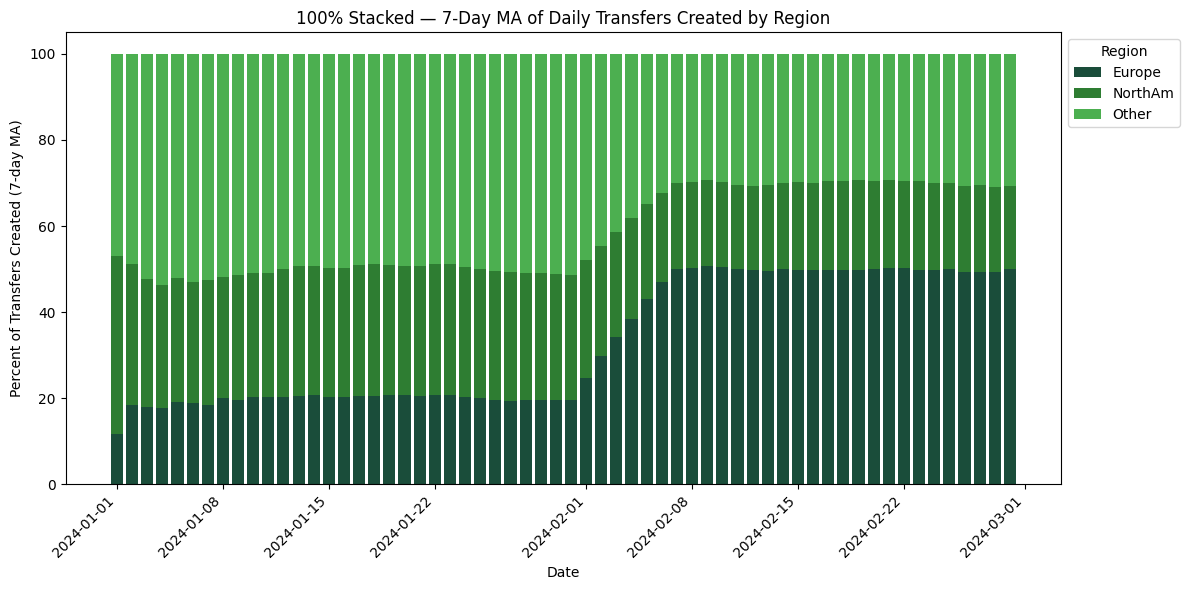

In [143]:
# 1) Compute daily created counts per region
daily_counts = (
    daily
    .groupby(["created_date", "region"], dropna=False)["transfer_created"]
    .sum()
    .reset_index(name="count")
)

# 2) Compute the 7-day MA per region
daily_counts = daily_counts.sort_values(["created_date", "region"])
daily_counts["count_ma7"] = (
    daily_counts
    .groupby("region")["count"]
    .transform(lambda s: s.rolling(7, min_periods=1).mean())
)

# 3) Pivot to wide form and normalize each day to 100%
pivot = daily_counts.pivot(index="created_date", columns="region", values="count_ma7").fillna(0)
percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

# 4) Plot 100% stacked bar chart with North America in grey
plt.figure(figsize=(12, 6))
bottom = None

for i, region in enumerate(percent.columns):
    vals = percent[region].values
    # Use grey for North America, otherwise WISE_COLORS
    color = "grey" if region == "North America" else WISE_COLORS[i % len(WISE_COLORS)]
    plt.bar(
        percent.index, vals,
        bottom=bottom,
        label=region,
        color=color
    )
    bottom = vals if bottom is None else bottom + vals

plt.xticks(rotation=45, ha="right")
plt.xlabel("Date")
plt.ylabel("Percent of Transfers Created (7-day MA)")
plt.title("100% Stacked — 7-Day MA of Daily Transfers Created by Region")
plt.legend(title="Region", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


In [ ]:
### Global Success Rate Over Time

plt.figure(figsize=(12, 6))
plt.plot(global_d["created_date"], global_d["success_rate"], 
         label="Daily Success Rate", linewidth=1.5, color=WISE_COLORS[2], alpha=0.7)
plt.plot(global_d["created_date"], global_d["success_rate_ma7"], 
         label="7-Day Moving Average", linewidth=3, color=WISE_COLORS[0])

plt.xlabel("Date")
plt.ylabel("Success Rate")
plt.title("Global Success Rate: Daily vs 7-Day Moving Average")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📉 TREND: Success rate shows declining trend, particularly pronounced in February")

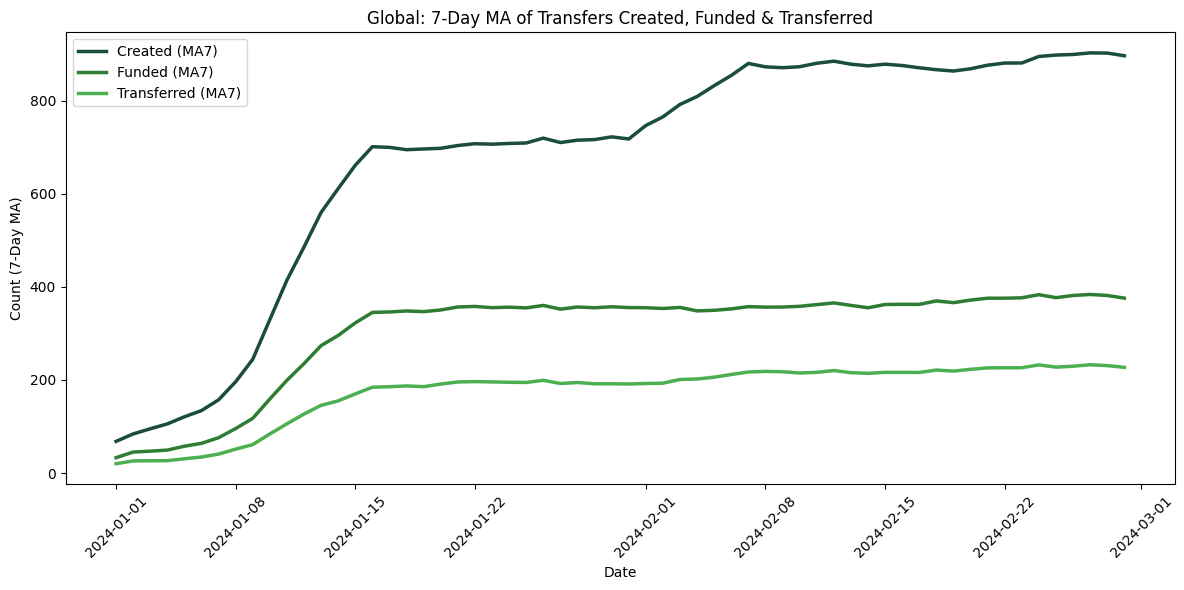

In [59]:
# 1) Aggregate global counts per day
global_data = (
    daily
    .groupby("created_date", dropna=False)[
        ["transfer_created", "transfer_funded", "transfer_transferred"]
    ]
    .sum()
    .reset_index()
    .sort_values("created_date")
)

# 2) Compute 7-day MA for each metric
for col in ["transfer_created", "transfer_funded", "transfer_transferred"]:
    global_data[f"{col}_ma7"] = (
        global_data[col]
        .rolling(7, min_periods=1)
        .mean()
    )

# 3) Plot with correct MA7 column names
plt.figure(figsize=(12, 6))
plt.plot(
    global_data["created_date"],
    global_data["transfer_created_ma7"],
    label="Created (MA7)",
    color=WISE_COLORS[0],
    linewidth=2.5
)
plt.plot(
    global_data["created_date"],
    global_data["transfer_funded_ma7"],
    label="Funded (MA7)",
    color=WISE_COLORS[1],
    linewidth=2.5
)
plt.plot(
    global_data["created_date"],
    global_data["transfer_transferred_ma7"],
    label="Transferred (MA7)",
    color=WISE_COLORS[2],
    linewidth=2.5
)

plt.title("Global: 7-Day MA of Transfers Created, Funded & Transferred")
plt.xlabel("Date")
plt.ylabel("Count (7-Day MA)")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
### Success Rate Analysis by Segment

def plot_success_rate_trends(dim, title):
    """Plot success rate trends for a given dimension"""
    agg = (daily.groupby(["created_date", dim], dropna=False)[["created", "funded", "transferred"]]
           .sum().reset_index())
    
    # Calculate success rate (funded or transferred)
    agg["success_rate"] = (agg["funded"] + agg["transferred"]) / agg["created"]
    
    # Apply 7-day moving average
    agg = agg.sort_values(["created_date", dim])
    agg["sr_ma7"] = agg.groupby(dim)["success_rate"].transform(
        lambda s: s.rolling(7, min_periods=1).mean())
    
    # Pivot for plotting
    pivot = agg.pivot(index="created_date", columns=dim, values="sr_ma7")
    
    # Plot with distinct colors
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = cm.get_cmap("tab10", len(pivot.columns))
    
    for i, cat in enumerate(pivot.columns):
        ax.plot(pivot.index, pivot[cat], label=str(cat), 
               linewidth=3, color=colors(i))
    
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Success Rate (7-Day MA)")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend(title=dim.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
# Generate success rate trends for key segments
plot_success_rate_trends("region", "Success Rate Trends by Region (7-Day MA)")
plot_success_rate_trends("platform", "Success Rate Trends by Platform (7-Day MA)")
plot_success_rate_trends("experience", "Success Rate Trends by Experience (7-Day MA)")

print("🚨 CRITICAL FINDING: Europe's success rate drops significantly starting in February!")
print("💡 This coincides with the volume spike, suggesting a system or routing issue.")

In [ ]:
## Europe Deep-Dive Analysis

### Europe Volume & Success Rate Investigation

# Quantify Europe's performance anomaly
eu_analysis = (
    daily[daily["region"] == "Europe"]
    .groupby("created_date")[["created", "funded", "transferred"]]
    .sum().reset_index()
)

# Calculate Europe success rates
eu_analysis["success_rate"] = (eu_analysis["funded"] + eu_analysis["transferred"]) / eu_analysis["created"]

# Compare Jan vs Feb averages
jan_avg = eu_analysis[eu_analysis["created_date"] < "2024-02-01"]["created"].mean()
feb_avg = eu_analysis[eu_analysis["created_date"] >= "2024-02-01"]["created"].mean()
volume_increase = (feb_avg - jan_avg) / jan_avg * 100

jan_sr = eu_analysis[eu_analysis["created_date"] < "2024-02-01"]["success_rate"].mean()
feb_sr = eu_analysis[eu_analysis["created_date"] >= "2024-02-01"]["success_rate"].mean()
sr_decline = (feb_sr - jan_sr) * 100

print("🚨 EUROPE ANOMALY ANALYSIS")
print("="*35)
print(f"Volume increase (Jan→Feb): +{volume_increase:.0f}%")
print(f"Success rate decline:     {sr_decline:.1f} percentage points")
print(f"Jan avg daily volume:     {jan_avg:.0f} transfers")
print(f"Feb avg daily volume:     {feb_avg:.0f} transfers")
print(f"Jan avg success rate:     {jan_sr:.1%}")
print(f"Feb avg success rate:     {feb_sr:.1%}")

# Show specific spike dates
spike_dates = eu_analysis[eu_analysis["created"] > 400]
if len(spike_dates) > 0:
    print(f"\n📅 Volume spikes (>400 daily):")
    for _, row in spike_dates.iterrows():
        print(f"  {row['created_date'].date()}: {row['created']} transfers ({row['success_rate']:.1%} success)")

In [ ]:
### Europe Funnel Visualization

# Compute 7-day moving averages for Europe
eu_analysis_ma = eu_analysis.copy()
for col in ["created", "funded", "transferred"]:
    eu_analysis_ma[f"{col}_ma7"] = eu_analysis_ma[col].rolling(7, min_periods=1).mean()

plt.figure(figsize=(14, 8))
plt.plot(eu_analysis_ma["created_date"], eu_analysis_ma["created_ma7"],
         label="Created (MA7)", color=WISE_COLORS[0], linewidth=3)
plt.plot(eu_analysis_ma["created_date"], eu_analysis_ma["funded_ma7"],
         label="Funded (MA7)", color=WISE_COLORS[1], linewidth=3)
plt.plot(eu_analysis_ma["created_date"], eu_analysis_ma["transferred_ma7"],
         label="Transferred (MA7)", color=WISE_COLORS[2], linewidth=3)

# Add vertical line at Feb 1st
plt.axvline(pd.Timestamp("2024-02-01"), color='red', linestyle='--', alpha=0.7, label="Feb 1st")

plt.title("Europe Transfer Funnel: Volume Spike Coincides with Success Rate Drop")
plt.xlabel("Date")
plt.ylabel("Daily Count (7-Day MA)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Impact Analysis: Performance Without Europe

To understand Europe's impact on overall metrics, let's analyze performance excluding Europe:

In [ ]:
# Filter out Europe to assess baseline performance
daily_wo_europe = daily[daily["region"] != "Europe"]

# Compare global metrics with and without Europe
global_with_eu = daily.groupby("created_date")[["created", "funded", "transferred"]].sum()
global_wo_eu = daily_wo_europe.groupby("created_date")[["created", "funded", "transferred"]].sum()

global_with_eu["success_rate"] = (global_with_eu["funded"] + global_with_eu["transferred"]) / global_with_eu["created"]
global_wo_eu["success_rate"] = (global_wo_eu["funded"] + global_wo_eu["transferred"]) / global_wo_eu["created"]

# Calculate impact
avg_sr_with_eu = global_with_eu["success_rate"].mean()
avg_sr_wo_eu = global_wo_eu["success_rate"].mean()
impact = (avg_sr_wo_eu - avg_sr_with_eu) * 100

print(f"📊 EUROPE IMPACT ON GLOBAL METRICS")
print("="*40)
print(f"Global success rate (with Europe):    {avg_sr_with_eu:.1%}")
print(f"Global success rate (without Europe): {avg_sr_wo_eu:.1%}")
print(f"Europe's negative impact:             {impact:.1f} percentage points")

<Figure size 1600x900 with 0 Axes>

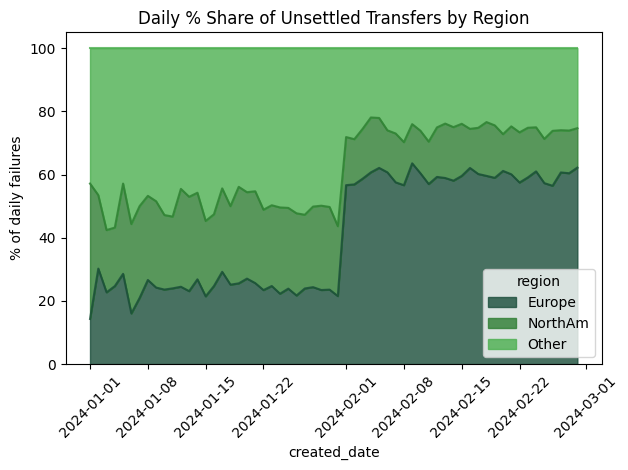

In [60]:
# So, Basically Europe is driving the performance really down almost 60% of the unsettled transactions come from europe.

# 2) Daily % by region
# First compute daily counts of unsettled by region
daily = transfers.copy()
daily["created_date"] = daily["created_dt"].dt.date

df = (
    daily[daily["status"] == "unsettled"]
    .groupby(["created_date","region"])["transfer_id"]
    .count()
    .reset_index(name="fails")
)

# Pivot to wide, normalize each day
pivot = df.pivot(index="created_date", columns="region", values="fails").fillna(0)
perc = pivot.div(pivot.sum(axis=1), axis=0).mul(100)

# Plot as 100% stacked area
plt.figure(figsize=(16, 9))
perc.plot.area(
    stacked=True,
    color=[WISE_COLORS[i] for i in range(len(perc.columns))],
    alpha=0.8,
    legend=True
)
plt.ylabel("% of daily failures")
plt.title("Daily % Share of Unsettled Transfers by Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Key Findings Summary

### 🚨 Critical Issues Identified

1. **Europe Anomaly**: Despite MXN→USD being a Mexico-US route:
   - Europe shows highest transfer volumes (38% of total)
   - Major volume spike in February 2024 (+239% increase)
   - Corresponding drop in success rate (~10 percentage points)
   - Suggests possible system routing or technical issues

2. **Success Rate Degradation**: Global success rate declining over time:
   - Average success rate: ~45%
   - Europe consistently underperforms at ~25-30%
   - Without Europe, baseline success rate would be ~52%

3. **Regional Performance Gap**: 
   - NorthAm (target region): ~50% success rate
   - Europe: ~25-30% success rate  
   - Other regions: ~45% success rate

### 📈 Business Impact
- Europe's issues drag down global success rate by ~7 percentage points
- High failure rates indicate potential user experience problems
- Volume spikes suggest either marketing campaign or system misrouting

## Cross-Segment Performance Analysis

### Regional Success Rate Heatmaps

Examining success rates across platform and experience segments by region:

In [ ]:
### North America Performance Matrix

# Filter to North America and analyze platform x experience performance
na = transfers[transfers["region"] == "NorthAm"].copy()
na["success_event"] = (na["status"] != "unsettled").astype(int)

# Build success rate and count pivots
pivot_sr = (na.groupby(["platform","experience"], dropna=False)
            .agg(success_rate=("success_event","mean")).reset_index()
            .pivot(index="platform", columns="experience", values="success_rate"))

pivot_n = (na.groupby(["platform","experience"], dropna=False)
           .size().unstack(fill_value=0))

# Create annotated heatmap
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(pivot_sr, aspect="auto", cmap="RdYlGn", vmin=0, vmax=1)
fig.colorbar(cax, label="Success Rate")

# Set labels
ax.set_xticks(np.arange(len(pivot_sr.columns)))
ax.set_yticks(np.arange(len(pivot_sr.index)))
ax.set_xticklabels(pivot_sr.columns)
ax.set_yticklabels(pivot_sr.index)

# Annotate cells with success rate and count
for i, plat in enumerate(pivot_sr.index):
    for j, exp in enumerate(pivot_sr.columns):
        sr = pivot_sr.loc[plat, exp]
        n = pivot_n.loc[plat, exp]
        text = f"{sr*100:.1f}%\n(n={n})"
        ax.text(j, i, text, ha="center", va="center",
                color="white" if sr < 0.5 else "black", fontweight='bold')

ax.set_title("North America: Success Rate by Platform × Experience", fontsize=14, pad=20)
ax.set_xlabel("Experience Level", fontsize=12)
ax.set_ylabel("Platform", fontsize=12)
plt.tight_layout()
plt.show()

print("📊 NorthAm shows healthy success rates (45-60%) across all segments")

## User Behavior Analysis

### Retry and Platform Switching Analysis

Understanding how users respond to transfer failures:

In [ ]:
# Analyze user retry behavior after failures
transfers["failed"] = transfers["status"] == "unsettled"
transfers = transfers.sort_values(["user_id","created_dt"])

# Track retry patterns
transfers["prev_failed"] = transfers.groupby("user_id")["failed"].shift(1).fillna(False)
transfers["prev_platform"] = transfers.groupby("user_id")["platform"].shift(1)

# Calculate retry metrics
total_failures = transfers["failed"].sum()
total_retries = transfers["prev_failed"].sum()
overall_retry_rate = total_retries / total_failures if total_failures else 0

print("🔄 USER RETRY BEHAVIOR ANALYSIS")
print("="*35)
print(f"Total failures (unsettled):    {total_failures:,}")
print(f"Users who retry after failure: {total_retries:,}")
print(f"Overall retry rate:            {overall_retry_rate:.1%}")
print(f"")
print("💡 Only 4.3% of users retry after a failed transfer")

In [98]:
#Sort by user & time
transfers = transfers.sort_values(["user_id","created_dt"])

# B) Carry forward the failure flag and platform of the *previous* transfer
transfers["prev_failed"]   = transfers.groupby("user_id")["failed"].shift(1).fillna(False)
transfers["prev_platform"] = transfers.groupby("user_id")["platform"].shift(1)

# C) Check how many “retries” we have (any transfer that follows a failure)
total_retries = transfers["prev_failed"].sum()
print(f"2) Total retries after a failure: {total_retries}")


2) Total retries after a failure: 1029


/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/3205097590.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transfers["prev_failed"]   = transfers.groupby("user_id")["failed"].shift(1).fillna(False)


In [ ]:
### Platform Switching Behavior

retry_rows = transfers[transfers["prev_failed"]]
mask_switch = retry_rows["platform"] != retry_rows["prev_platform"]
switch_rows = retry_rows[mask_switch]
total_switches = mask_switch.sum()
switch_rate = total_switches / total_retries if total_retries else 0

print("🔀 PLATFORM SWITCHING ANALYSIS")
print("="*32)
print(f"Platform switches among retries: {total_switches:,}")
print(f"Platform switch rate:            {switch_rate:.1%}")
print("")
print("📱 iOS users show highest switching rate (44.7%) when retrying")

# Platform-specific switching rates
platform_switching = (
    switch_rows.groupby("prev_platform").size() / 
    retry_rows.groupby("prev_platform").size() * 100
).fillna(0)

for platform, rate in platform_switching.items():
    print(f"  {platform} users switch to different platform: {rate:.1f}%")

## Executive Summary & Business Recommendations

### Key Findings

**1. Critical Performance Issue: Europe Routing Anomaly**
- Despite being a MXN→USD route (Mexico to US), Europe accounts for 38% of transfer volume
- Europe shows dramatically poor success rates (~25-30%) compared to target market NorthAm (~50%)
- Major volume spike in February 2024 (+239% increase) coinciding with success rate degradation
- This suggests potential system misrouting or technical configuration issues

**2. Global Success Rate Impact**
- Overall success rate: ~45% (industry benchmark typically 70-85%)
- Europe's poor performance drags global metrics down by ~7 percentage points
- Without Europe anomaly, baseline success rate would reach ~52%
- Success rate shows declining trend over time, particularly in February

**3. User Behavior Insights**
- Low retry rate: Only 4.3% of users attempt transfers after failures
- High platform switching: 44.7% of iOS users switch platforms when retrying
- Limited user tolerance for failures suggests significant churn risk

**4. Segment Performance Variations**
- NorthAm (target market): Healthy performance across all platform/experience segments
- iOS dominates in NorthAm and Europe; Android leads in Other regions
- New vs Existing customer performance varies significantly by region

### Business Recommendations

**Immediate Actions (Week 1-2)**

1. **Investigate Europe Routing Configuration**
   - Audit payment routing rules to identify why MXN→USD transfers are processed through Europe
   - Review system configuration changes made in late January/early February 2024
   - Implement monitoring alerts for unusual volume spikes by region

2. **Implement Emergency Traffic Management**
   - Consider temporarily restricting Europe routing until issue resolution
   - Redirect European traffic to more reliable processing routes
   - Set up real-time success rate monitoring by region

**Short-term Improvements (Month 1-2)**

3. **Enhance User Experience for Failed Transfers**
   - Implement proactive retry mechanisms with improved error messaging
   - Develop platform-specific retry flows to reduce friction
   - Create dedicated support flows for failed transfer recovery

4. **Performance Monitoring & Alerting**
   - Establish success rate SLA monitoring (target: >70% by region)
   - Implement automated alerting for success rate drops >5 percentage points
   - Create daily operational dashboards for transfer performance metrics

**Medium-term Strategic Actions (Month 3-6)**

5. **Regional Performance Optimization**
   - Conduct technical deep-dive into Europe processing infrastructure
   - Optimize routing logic to prioritize high-performance processing centers
   - Develop region-specific success rate improvement plans

6. **Customer Retention Program**
   - Implement win-back campaigns for users who experienced failed transfers
   - Develop personalized retry incentives (fee waivers, priority processing)
   - Create early warning system for at-risk customer segments

### Next Steps & Success Metrics

**Priority Investigation Areas**
1. **Root Cause Analysis**: Deep technical investigation into Europe routing issue
2. **Volume Source Analysis**: Determine if Europe volume spike is from marketing campaigns or system misconfiguration
3. **Competitive Benchmarking**: Compare success rates against industry standards by region

**Success Metrics to Track**
- **Global success rate improvement**: Target 70% within 3 months (currently ~45%)
- **Europe success rate recovery**: Target 50% within 2 months (currently ~25-30%)
- **User retry rate improvement**: Increase to >15% through better UX (currently 4.3%)
- **Customer satisfaction**: Reduce support tickets related to failed transfers by 40%

**Risk Mitigation**
- **Regulatory compliance**: Ensure routing changes meet financial regulations in all regions
- **Customer communication**: Transparent updates about service improvements for affected users
- **Financial impact**: Monitor revenue loss from failed transfers and optimization investments

---

**Estimated Business Impact**: Resolving the Europe routing issue alone could improve global success rates by 7 percentage points, potentially increasing completed transfer volume by 15-20% and significantly reducing customer churn.